# Conclave Simulation Analysis

This notebook analyses the data from `combined_results_snellius.csv` to understand the dynamics of consensus in a simulated conclave.

The key research questions are:
1. Under what parameter settings does the conclave converge on a consensus candidate versus becoming polarised or grid-locked?
2. How do the two control knobs affect that outcome?
    - **Temperature (`temperature`)**: Higher values add payoff-independent randomness.
    - **Rationality (`rationality`)**: A value of 1 represents utility-maximising behavior, while 0 represents random choice.

# Conclave Simulation Analysis

This notebook analyses the data from `combined_results_snellius.csv` to understand the dynamics of consensus in a simulated conclave.

The key research questions are:
1. Under what parameter settings does the conclave converge on a consensus candidate versus becoming polarised or grid-locked?
2. How do the two control knobs affect that outcome?
    - **Temperature (`temperature`)**: Higher values add payoff-independent randomness.
    - **Rationality (`rationality`)**: A value of 1 represents utility-maximising behavior, while 0 represents random choice.

# Conclave Simulation Analysis

This notebook analyses the data from `combined_results_snellius.csv` to understand the dynamics of consensus in a simulated conclave.

The key research questions are:
1. Under what parameter settings does the conclave converge on a consensus candidate versus becoming polarised or grid-locked?
2. How do the two control knobs affect that outcome?
    - **Temperature (`temperature`)**: Higher values add payoff-independent randomness.
    - **Rationality (`rationality`)**: A value of 1 represents utility-maximising behavior, while 0 represents random choice.

## 1. Imports & Data Load

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global aesthetics for plots
sns.set_theme(context="talk", style="whitegrid")

In [6]:
# Load the dataset
# The notebook is in analysis/, the data in results/
try:
    df = pd.read_csv("../results/combined_results_snellius.csv")
except FileNotFoundError:
    print("Could not find the data file. Make sure 'combined_results_snellius.csv' is in the 'results' directory.")

## 2. Sanity Checks

Before diving into the analysis, let's perform some basic checks to understand the structure and quality of the data.

In [7]:
# Check for column name aliases
if 'mixture' in df.columns and 'rationality' not in df.columns:
    df.rename(columns={'mixture': 'rationality'}, inplace=True)
if 'p' in df.columns and 'rationality' not in df.columns:
    df.rename(columns={'p': 'rationality'}, inplace=True)

# --- Basic Data Inspection ---
print("Data Shape:", df.shape)
print("\nMissing Values:\n", df.isna().sum())

# --- Parameter Space ---
param_counts = df[['temperature', 'rationality']].nunique()
print(f"\nFound {param_counts['temperature']} unique temperatures and {param_counts['rationality']} unique rationality values.")

# --- Outcome Distribution ---
if 'run_outcome' in df.columns:
    print("\nOutcome Counts:\n", df['run_outcome'].value_counts())

Data Shape: (1275, 17)

Missing Values:
 run_id                             0
temperature                        0
rationality                        0
consensus_reached                  0
rounds_to_consensus                0
total_rounds                       0
final_leading_margin               0
polarisation_start                 0
polarisation_peak                  0
polarisation_final                 0
max_gridlock_span                  0
gridlock_end_round              1196
mean_switches_per_agent            0
switch_probability_per_round       0
mean_switches_per_round            0
run_outcome                        0
winner_name                        0
dtype: int64

Found 5 unique temperatures and 5 unique rationality values.

Outcome Counts:
 run_outcome
CONSENSUS    1275
Name: count, dtype: int64


## 4. Visualizations

Now, let's visualize the relationships between the parameters and the outcomes.

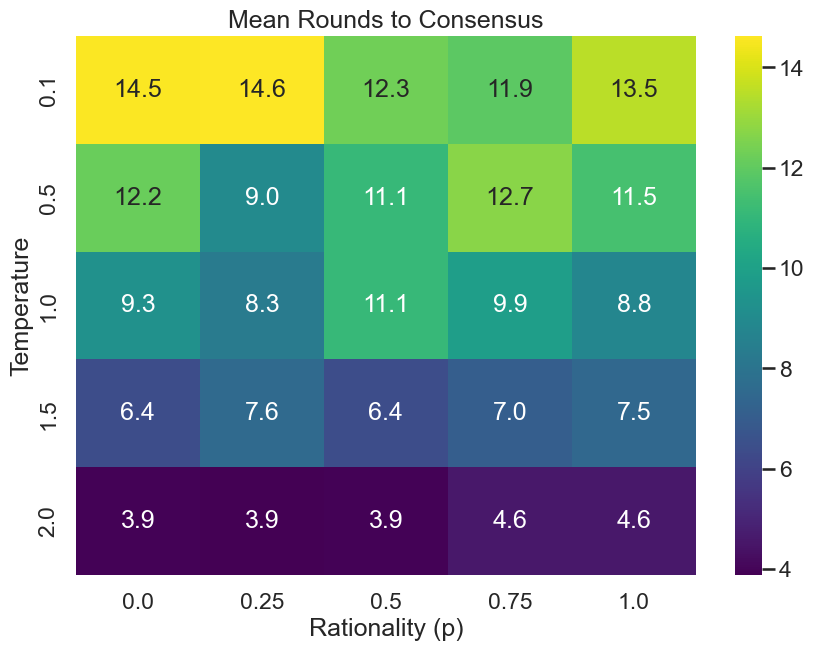

In [9]:
# Pivot the data for the heatmap
rounds_pivot = df.pivot_table(index='temperature', columns='rationality', values='rounds_to_consensus', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(rounds_pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Mean Rounds to Consensus")
plt.xlabel("Rationality (p)")
plt.ylabel("Temperature")
plt.show()

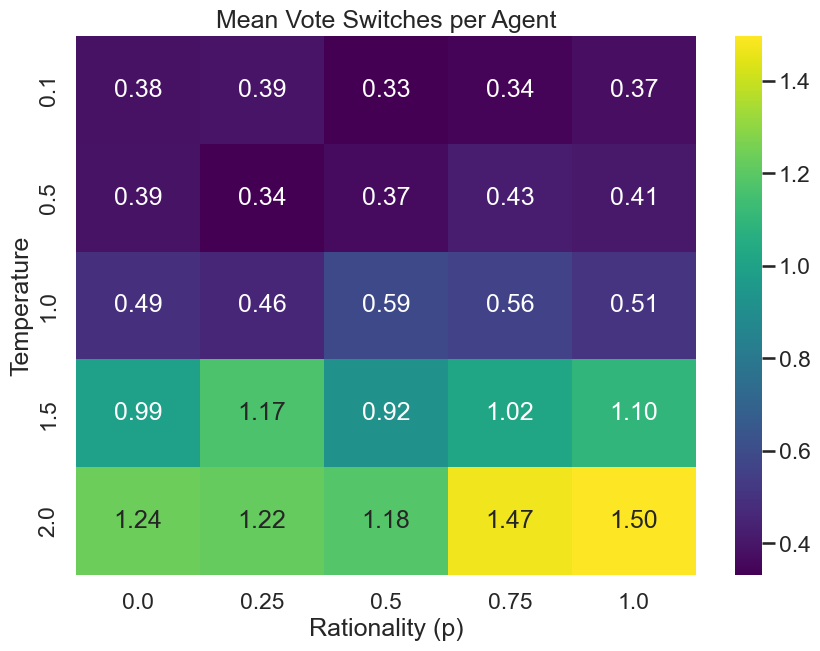

In [10]:
# Pivot the data for the heatmap
switches_pivot = df.pivot_table(index='temperature', columns='rationality', values='mean_switches_per_agent', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(switches_pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("Mean Vote Switches per Agent")
plt.xlabel("Rationality (p)")
plt.ylabel("Temperature")
plt.show()

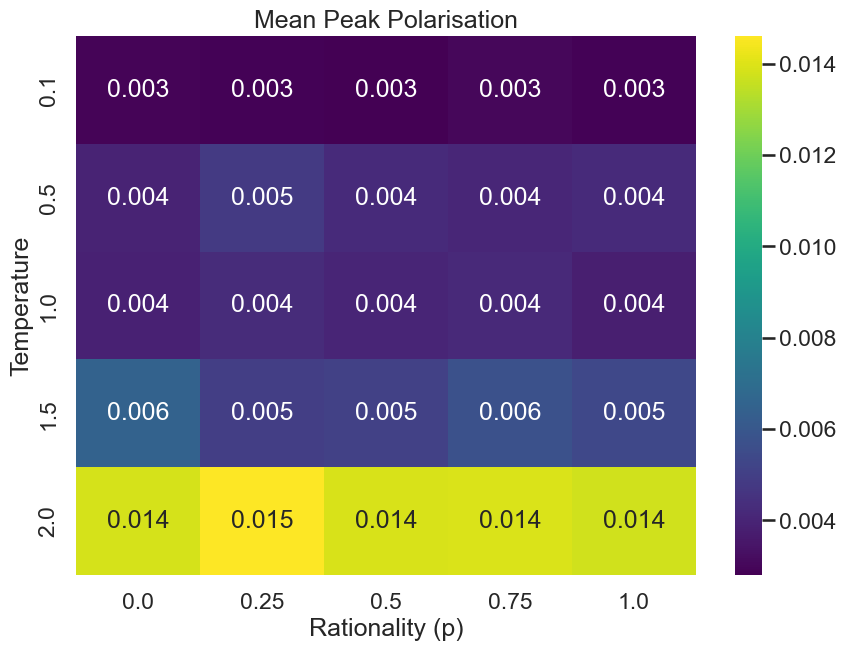

In [11]:
# Pivot the data for the heatmap
polarisation_pivot = df.pivot_table(index='temperature', columns='rationality', values='polarisation_peak', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(polarisation_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Mean Peak Polarisation")
plt.xlabel("Rationality (p)")
plt.ylabel("Temperature")
plt.show()

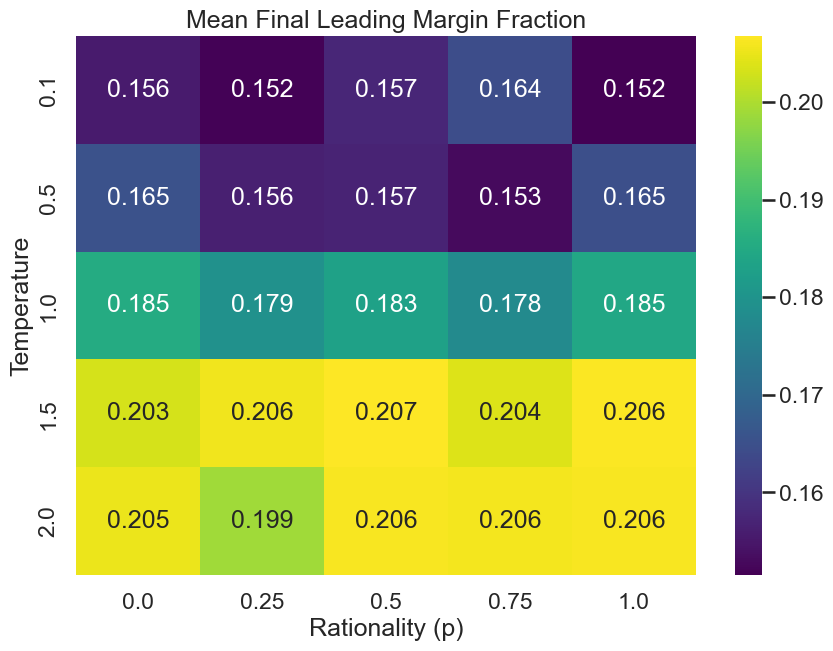

In [12]:
# Calculate final leading margin fraction
df['final_leading_margin_fraction'] = df['final_leading_margin'] / 120

# Pivot the data for the heatmap
margin_pivot = df.pivot_table(index='temperature', columns='rationality', values='final_leading_margin_fraction', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(margin_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Mean Final Leading Margin Fraction")
plt.xlabel("Rationality (p)")
plt.ylabel("Temperature")
plt.show()

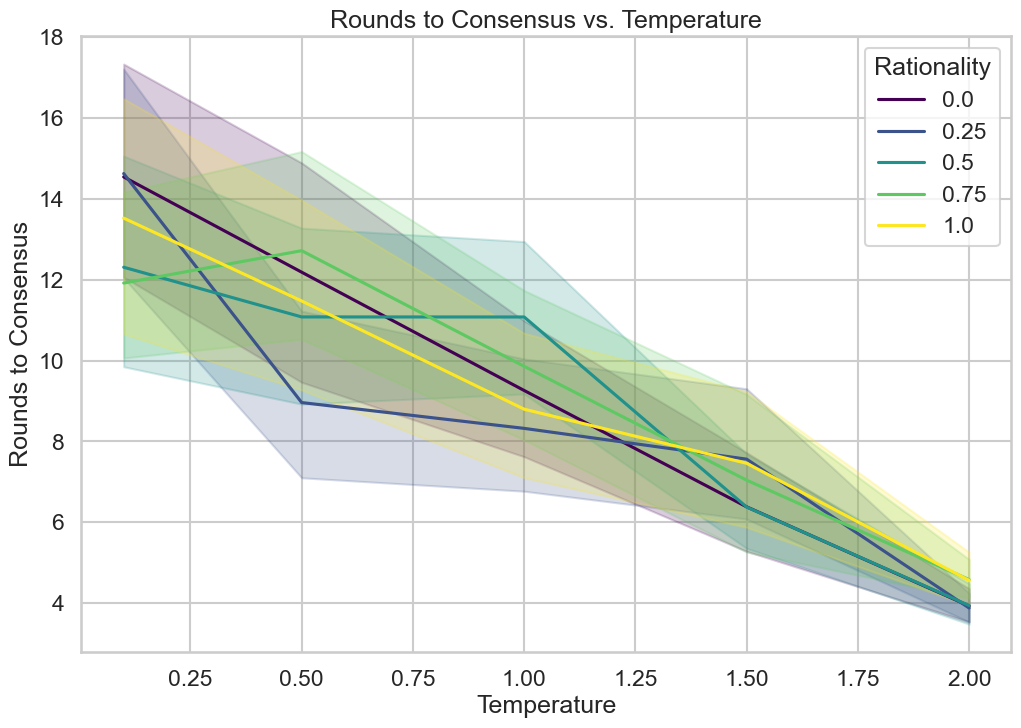

In [13]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='temperature', y='rounds_to_consensus', hue='rationality', palette='viridis')
plt.title("Rounds to Consensus vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Rounds to Consensus")
plt.legend(title='Rationality')
plt.show()

### Interpretation

This line plot confirms the trend seen in the first heatmap. For most rationality levels, the number of rounds to consensus increases with temperature. It also highlights the non-linear relationship, where the fastest convergence often occurs at mid-range rationality values.

## 5. Conditional Follow-up

Next, we'll investigate gridlock scenarios. The following cells will behave differently depending on whether any gridlock was observed in the data.

In [14]:
has_gridlock = (df["run_outcome"] == "GRIDLOCK").any()

if has_gridlock:
    print("Gridlock occurred in some runs. Analyzing gridlocked runs...")
    gridlocked_runs = df[df['run_outcome'] == 'GRIDLOCK']
    print(gridlocked_runs[['run_id', 'temperature', 'rationality', 'max_gridlock_span']])
    
    # Try to plot vote trajectories for the first gridlocked run
    if not gridlocked_runs.empty:
        run_id_to_check = gridlocked_runs.iloc[0]['run_id']
        try:
            vote_trajectory_df = pd.read_csv(f"../results/vote_trajectories/{run_id_to_check}.csv")
            plt.figure(figsize=(12, 8))
            sns.lineplot(data=vote_trajectory_df, x='round', y='votes', hue='candidate')
            plt.title(f'Vote Trajectory for Gridlocked Run: {run_id_to_check}')
            plt.xlabel('Round')
            plt.ylabel('Vote Share')
            plt.show()
        except FileNotFoundError:
            print(f"TODO: add vote-trajectory file for run {run_id_to_check}")
else:
    print("No gridlock occurred in any of the simulation runs.")

No gridlock occurred in any of the simulation runs.


### No Gridlock Observed

In this dataset, no runs resulted in gridlock. This suggests that with the current parameter space, the system is always able to converge to a consensus. 

**TODO for future experiments:**
*   **Lower Rationality**: Explore even lower values for rationality, approaching purely random voting.
*   **Higher Quorum**: Increase the threshold for consensus to be more stringent than a simple majority.
*   **Introduce Fatigue**: Implement a mechanism where agents are less likely to switch their votes after a certain number of rounds.

## 1. Imports & Data Load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global aesthetics for plots
sns.set_theme(context="talk", style="whitegrid")

In [ ]:
# Load the dataset
# The notebook is in analysis/, the data in results/
try:
    df = pd.read_csv("../results/combined_results_snellius.csv")
except FileNotFoundError:
    print("Could not find the data file. Make sure 'combined_results_snellius.csv' is in the 'results' directory.")
    df = pd.DataFrame() # Create an empty dataframe to avoid errors in subsequent cells

## 2. Sanity Checks

Before diving into the analysis, let's perform some basic checks to understand the structure and quality of the data.

In [ ]:
if not df.empty:
    # Check for column name aliases
    if 'mixture' in df.columns and 'rationality' not in df.columns:
        df.rename(columns={'mixture': 'rationality'}, inplace=True)
    if 'p' in df.columns and 'rationality' not in df.columns:
        df.rename(columns={'p': 'rationality'}, inplace=True)

    # --- Basic Data Inspection ---
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isna().sum())

    # --- Parameter Space ---
    param_counts = df[['temperature', 'rationality']].nunique()
    print(f"\nFound {param_counts['temperature']} unique temperatures and {param_counts['rationality']} unique rationality values.")

    # --- Outcome Distribution ---
    if 'run_outcome' in df.columns:
        print("\nOutcome Counts:\n", df['run_outcome'].value_counts())
else:
    print("DataFrame is empty, skipping sanity checks.")

## 1. Imports & Data Load

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global aesthetics for plots
sns.set_theme(context="talk", style="whitegrid")

In [16]:
# Load the dataset
# The notebook is in analysis/, the data in results/
try:
    df = pd.read_csv("../results/combined_results_snellius.csv")
except FileNotFoundError:
    print("Could not find the data file. Make sure 'combined_results_snellius.csv' is in the 'results' directory.")
    df = pd.DataFrame() # Create an empty dataframe to avoid errors in subsequent cells

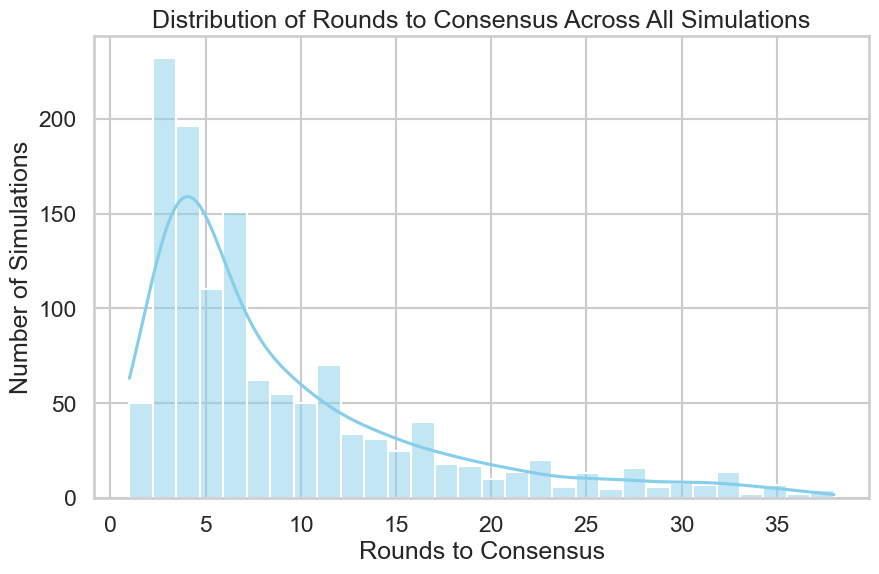

In [17]:
# Distribution plot: Number of rounds to consensus across all simulations
if not df.empty and 'rounds_to_consensus' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['rounds_to_consensus'].dropna(), bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Rounds to Consensus Across All Simulations')
    plt.xlabel('Rounds to Consensus')
    plt.ylabel('Number of Simulations')
    plt.show()
else:
    print('Column "rounds_to_consensus" not found or DataFrame is empty.')